In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

# switch the renderer to use black and white mode and increase the font size for legends
IPythonConsole.drawOptions.useBWAtomPalette()
IPythonConsole.drawOptions.legendFontSize=24

# enable the 3D viewer for 3D conformers. You need to have py3Dmol installed for this to work:
#   conda install py3dmol
IPythonConsole.ipython_3d = True

import rdkit
print(rdkit.__version__)

2024.09.5


In [2]:
import lwreg

# get the base lwreg configuration:
config = lwreg.utils.defaultConfig()
config

{'dbname': './testdb.sqlt',
 'dbtype': 'sqlite3',
 'standardization': 'fragment',
 'removeHs': 1,
 'useTautomerHashv2': 0,
 'registerConformers': 0,
 'numConformerDigits': 3,
 'lwregSchema': ''}

Now we set some configuration parameters.

The two important things here are that we need to ensure that we are in conformer mode and that the only standardization that is done is to canonicalize the orientation of the conformers (i.e translate them to the origin and transform them to the principle axes frame).

In [3]:
# set the name of the database we'll work with:
config['dbname'] = 'jupyter_conformer_demo.sqlt'

# set the database to be conformer mode:
config['registerConformers'] = 1

# these are just standard conformers, so we want to canonicalize their orientation
# (i.e. align them to the pr)
config['standardization'] = 'canonicalize'

# now tell lwreg to use ths configuration as the default in all other commands
# we call in this session:
lwreg.set_default_config(config)

Initialize the database. 
    
**Note** that this erases everything in the current database, so be very careful with this command!

In [4]:
lwreg.initdb()

This will destroy any existing information in the registration database.


  are you sure? [yes/no]:  yes


True

## Register some compounds

An aside for those who care: the molecules here were constructed from smiles and the charge parent was generated. For each molecule, at most 5 tautomers were enumerated, for each tautomer at most 5 stereoisomers were enumerated, and then finally at most 10 conformers were generated using srETKDGv3 with an RMS pruning value of 0.5. These molecules were then written to the SDF that we read from in this tutorial

Here's the code used for the enumeration and conformer generation:
```python
ps = rdDistGeom.srETKDGv3()
ps.randomSeed = 0xbad5eed
ps.pruneRmsThresh = 0.5
w = Chem.SDWriter('../tutorial/tutorial_data/mols_with_confs.sdf')
tenum = rdMolStandardize.TautomerEnumerator()
for m in ms:
    print(m.GetProp('_Name'))
    tauts = tenum.Enumerate(m)
    for ti,taut in enumerate(tauts):
        print('\t',ti)
        Chem.SanitizeMol(taut)
        taut = Chem.AddHs(taut)
        nHere = 0
        for si,siso in enumerate(EnumerateStereoisomers.EnumerateStereoisomers(taut)):
            print('\t\t',si)
            mh = Chem.AddHs(siso)
            mh.SetProp('_Name',f'{mh.GetProp("_Name")}-{ti+1}-{si+1}')
            cids = rdDistGeom.EmbedMultipleConfs(mh,10,ps)
            for cid in cids:
                w.write(mh,confId=cid)
            w.flush()
            if si>5:
                break
        if ti>=5:
            break
w.close()
```

Read in a set of 3D molecules:

In [5]:
with Chem.SDMolSupplier('./tutorial_data/mols_with_confs.sdf',removeHs=False) as suppl:
    ms = [x for x in suppl]
len(ms)

125

The data set has 125 members, but there are multiple conformers for each molecule.
                                                              
How many unique molecules are there?

In [6]:
len(set(Chem.MolToSmiles(m) for m in ms))

15

The best way to register a set of compounds is the `bulk_register()` function. In conformer mode, this returns a tuple of (molregnos,conformer_id) tuples for the registered molecules:

In [7]:
res = lwreg.bulk_register(mols=ms)

In [8]:
len(res)

125

In [9]:
res[:5]

((1, 1), (1, 2), (1, 3), (1, 4), (1, 5))

## Running queries and retrieving conformers

Here's our query molecule:

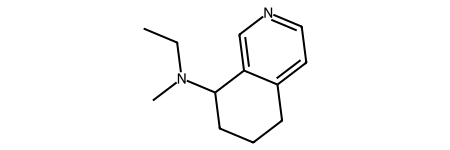

In [10]:
smi = 'CCN(C)C1CCCc2ccncc12'
Chem.MolFromSmiles(smi)

The default behavior of the `query()` function is to return exact matches. This query has an unspecified stereo center, but all of the compounds in the database have their stereochemistry fully specified since they are 3D. So with default arguments to `query` we get no results: 

In [11]:
lwreg.query(smiles=smi)

[]

If we query using the `no_stereo_smiles` layer we get the molregnos for the two stereoisomers we have registered:

In [13]:
ids = lwreg.query(smiles=smi,
            layers=lwreg.utils.HashLayer.NO_STEREO_SMILES)
ids

[1, 2]

We can also use the `query()` function to retrieve all of the conformer IDs for a list of molregnos:

In [14]:
confIds = lwreg.query(ids=ids)
len(confIds)

11

The result is a list of (molregno, conformer_id) tuples:

In [17]:
confIds[:3]

[(1, 1), (1, 2), (1, 3)]

The `retrieve()` function allows us to fetch those conformers:

In [18]:
res = lwreg.retrieve(ids=confIds)
len(res)

11

The individual results are, as always with `retrieve()`, (mol_data,format) tuples. With conformers the format is aways `mol` since the conformers are stored as V3000 Mol blocks.

In [20]:
res[(1,1)]

('CHEMBL1794855-1-1\n     RDKit          3D\n\n  0  0  0  0  0  0  0  0  0  0999 V3000\nM  V30 BEGIN CTAB\nM  V30 COUNTS 32 33 0 0 0\nM  V30 BEGIN ATOM\nM  V30 1 C 3.847123 0.293644 0.515021 0\nM  V30 2 C 3.031191 -0.860458 0.101065 0\nM  V30 3 N 1.593335 -0.817106 0.397340 0\nM  V30 4 C 1.228970 -2.262662 0.255587 0\nM  V30 5 C 0.825301 -0.199915 -0.684788 0 CFG=2\nM  V30 6 C 1.282672 1.246759 -0.925551 0\nM  V30 7 C 0.835870 2.136600 0.146114 0\nM  V30 8 C -0.699256 2.210727 0.183787 0\nM  V30 9 C -1.300210 0.898238 0.104970 0\nM  V30 10 C -2.650817 0.797431 0.451277 0\nM  V30 11 C -3.353963 -0.380443 0.358160 0\nM  V30 12 N -2.672072 -1.442213 -0.087062 0\nM  V30 13 C -1.372998 -1.381370 -0.436556 0\nM  V30 14 C -0.595146 -0.239232 -0.379366 0\nM  V30 15 H 4.672377 -0.096541 1.221346 0\nM  V30 16 H 4.461861 0.785746 -0.273232 0\nM  V30 17 H 3.304505 1.048644 1.108837 0\nM  V30 18 H 3.467399 -1.819240 0.522975 0\nM  V30 19 H 3.111916 -1.033649 -1.019040 0\nM  V30 20 H 2.128761 -2.816

Let's look at a few of those conformers:

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

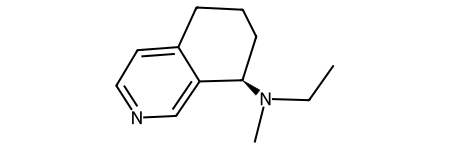

In [21]:
mol1 = Chem.MolFromMolBlock(res[(1,1)][0])
mol1

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

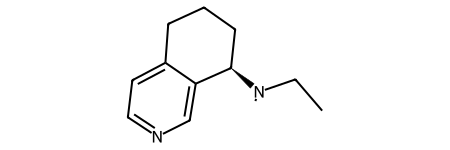

In [23]:
mol2 = Chem.MolFromMolBlock(res[(1,2)][0])
mol2

Now get a conformer for the other molregno, this is the other stereoisomer:

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

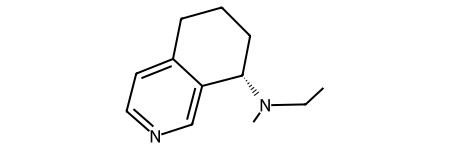

In [26]:
Chem.MolFromMolBlock(res[(2,7)][0])